In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Attack

In [2]:
#load MNIST
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)

batch_size = 10
epoch = 1
learning_rate = 0.001

adver_nums = 1000


# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Choose GPU
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

simple_model = Net().to(device)
optimizer1 = torch.optim.SGD(simple_model.parameters(),lr = learning_rate,momentum=0.9)
print (simple_model)


def train(model,optimizer):
  for i in range(epoch):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      loss = F.nll_loss(logit,target)
      model.zero_grad()

      loss.backward()
      optimizer.step()
      if j % 1000 == 0:
        print ('The{}the data, loss='.format(j,loss))
train(simple_model,optimizer1)

simple_model.eval()

def test(model,name):
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} Accuracy= {}'.format(name,correct_num/10000))

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


34it [00:05,  9.20it/s]

The0the data, loss=


1063it [00:07, 490.86it/s]

The1000the data, loss=


2047it [00:09, 495.80it/s]

The2000the data, loss=


3099it [00:11, 490.92it/s]

The3000the data, loss=


4063it [00:13, 457.13it/s]

The4000the data, loss=


5063it [00:16, 457.84it/s]

The5000the data, loss=


6000it [00:18, 328.25it/s]


In [3]:
test(simple_model,'simple model')

1000it [00:01, 776.40it/s]

tensor(9485, device='cuda:0')

simple model Accuracy= 0.9484999775886536


In [4]:
def optimize_linear(grad, eps, norm=np.inf):
    red_ind = list(range(1, len(grad.size())))
    avoid_zero_div = torch.tensor(1e-12, dtype=grad.dtype, device=grad.device)
    if norm == np.inf:
        # Take sign of gradient
        optimal_perturbation = torch.sign(grad)
    elif norm == 1:
        abs_grad = torch.abs(grad)
        sign = torch.sign(grad)
        red_ind = list(range(1, len(grad.size())))
        abs_grad = torch.abs(grad)
        ori_shape = [1] * len(grad.size())
        ori_shape[0] = grad.size(0)

        max_abs_grad, _ = torch.max(abs_grad.view(grad.size(0), -1), 1)
        max_mask = abs_grad.eq(max_abs_grad.view(ori_shape)).to(torch.float)
        num_ties = max_mask
        for red_scalar in red_ind:
            num_ties = torch.sum(num_ties, red_scalar, keepdim=True)
        optimal_perturbation = sign * max_mask / num_ties

        opt_pert_norm = optimal_perturbation.abs().sum(dim=red_ind)
        assert torch.all(opt_pert_norm == torch.ones_like(opt_pert_norm))
    elif norm == 2:
        square = torch.max(avoid_zero_div, torch.sum(grad ** 2, red_ind, keepdim=True))
        optimal_perturbation = grad / torch.sqrt(square)

        opt_pert_norm = (
            optimal_perturbation.pow(2).sum(dim=red_ind, keepdim=True).sqrt()
        )
        one_mask = (square <= avoid_zero_div).to(torch.float) * opt_pert_norm + (
            square > avoid_zero_div
        ).to(torch.float)
        assert torch.allclose(opt_pert_norm, one_mask, rtol=1e-05, atol=1e-08)
    else:
        raise NotImplementedError(
            "Only L-inf, L1 and L2 norms are " "currently implemented."
        )


    scaled_perturbation = eps * optimal_perturbation
    return scaled_perturbation

def clip_eta(eta, norm, eps):
    if norm not in [np.inf, 1, 2]:
        raise ValueError("norm must be np.inf, 1, or 2.")

    avoid_zero_div = torch.tensor(1e-12, dtype=eta.dtype, device=eta.device)
    reduc_ind = list(range(1, len(eta.size())))
    if norm == np.inf:
        eta = torch.clamp(eta, -eps, eps)
    else:
        if norm == 1:
            raise NotImplementedError("L1 clip is not implemented.")
            norm = torch.max(
                avoid_zero_div, torch.sum(torch.abs(eta), dim=reduc_ind, keepdim=True)
            )
        elif norm == 2:
            norm = torch.sqrt(
                torch.max(
                    avoid_zero_div, torch.sum(eta ** 2, dim=reduc_ind, keepdim=True)
                )
            )
        factor = torch.min(
            torch.tensor(1.0, dtype=eta.dtype, device=eta.device), eps / norm
        )
        eta *= factor
    return eta

In [5]:
def fast_gradient_method(
    model_fn,
    x,
    eps,
    norm,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    sanity_checks=False,
):
    if norm not in [np.inf, 1, 2]:
        raise ValueError(
            "Norm order must be either np.inf, 1, or 2, got {} instead.".format(norm)
        )
    if eps < 0:
        raise ValueError(
            "eps must be greater than or equal to 0, got {} instead".format(eps)
        )
    if eps == 0:
        return x
    if clip_min is not None and clip_max is not None:
        if clip_min > clip_max:
            raise ValueError(
                "clip_min must be less than or equal to clip_max, got clip_min={} and clip_max={}".format(
                    clip_min, clip_max
                )
            )

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        assert_ge = torch.all(
            torch.ge(x, torch.tensor(clip_min, device=x.device, dtype=x.dtype))
        )
        asserts.append(assert_ge)

    if clip_max is not None:
        assert_le = torch.all(
            torch.le(x, torch.tensor(clip_max, device=x.device, dtype=x.dtype))
        )
        asserts.append(assert_le)


    x = x.clone().detach().to(torch.float).requires_grad_(True)
    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        _, y = torch.max(model_fn(x), 1)

    # Compute loss
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(model_fn(x), y)
    # If attack is targeted, minimize loss of target label rather than maximize loss of correct label
    if targeted:
        loss = -loss

    # Define gradient of loss wrt input
    loss.backward()
    optimal_perturbation = optimize_linear(x.grad, eps, norm)

    # Add perturbation to original example to obtain adversarial example
    adv_x = x + optimal_perturbation

    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        if clip_min is None or clip_max is None:
            raise ValueError(
                "One of clip_min and clip_max is None but we don't currently support one-sided clipping"
            )
        adv_x = torch.clamp(adv_x, clip_min, clip_max)

    if sanity_checks:
        assert np.all(asserts)
    return adv_x

def projected_gradient_descent(
    model_fn,
    x,
    eps,
    eps_iter,
    nb_iter,
    norm,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    rand_init=True,
    rand_minmax=None,
    sanity_checks=True,
):
    if norm == 1:
        raise NotImplementedError("No")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
    if eps < 0:
        raise ValueError(
            "eps must be greater than or equal to 0, got {} instead".format(eps)
        )
    if eps == 0:
        return x
    if eps_iter < 0:
        raise ValueError(
            "eps_iter must be greater than or equal to 0, got {} instead".format(
                eps_iter
            )
        )
    if eps_iter == 0:
        return x

    assert eps_iter <= eps, (eps_iter, eps)
    if clip_min is not None and clip_max is not None:
        if clip_min > clip_max:
            raise ValueError(
                "clip_min must be less than or equal to clip_max, got clip_min={} and clip_max={}".format(
                    clip_min, clip_max
                )
            )

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        assert_ge = torch.all(
            torch.ge(x, torch.tensor(clip_min, device=x.device, dtype=x.dtype))
        )
        asserts.append(assert_ge)

    if clip_max is not None:
        assert_le = torch.all(
            torch.le(x, torch.tensor(clip_max, device=x.device, dtype=x.dtype))
        )
        asserts.append(assert_le)

    # Initialize loop variables
    if rand_init:
        if rand_minmax is None:
            rand_minmax = eps
        eta = torch.zeros_like(x).uniform_(-rand_minmax, rand_minmax)
    else:
        eta = torch.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = torch.clamp(adv_x, clip_min, clip_max)

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        _, y = torch.max(model_fn(x), 1)

    i = 0
    while i < nb_iter:
        adv_x = fast_gradient_method(
            model_fn,
            adv_x,
            eps_iter,
            norm,
            clip_min=clip_min,
            clip_max=clip_max,
            y=y,
            targeted=targeted,
        )

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        if clip_min is not None or clip_max is not None:
            adv_x = torch.clamp(adv_x, clip_min, clip_max)
        i += 1

    asserts.append(eps_iter <= eps)
    if norm == np.inf and clip_min is not None:
        asserts.append(eps + clip_min <= clip_max)

    if sanity_checks:
        assert np.all(asserts)
    return adv_x

INF = float("inf")


def carlini_wagner_l2(
    model_fn,
    x,
    n_classes,
    y=None,
    targeted=False,
    lr=5e-3,
    confidence=0,
    clip_min=0,
    clip_max=1,
    initial_const=1e-2,
    binary_search_steps=5,
    max_iterations=1000,
):

    def compare(pred, label, is_logits=False):

        # Convert logits to predicted class if necessary
        if is_logits:
            pred_copy = pred.clone().detach()
            pred_copy[label] += -confidence if targeted else confidence
            pred = torch.argmax(pred_copy)

        return pred == label if targeted else pred != label

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        pred = model_fn(x)
        y = torch.argmax(pred, 1)

    # Initialize some values needed for binary search on const
    lower_bound = [0.0] * len(x)
    upper_bound = [1e10] * len(x)
    const = x.new_ones(len(x), 1) * initial_const

    o_bestl2 = [INF] * len(x)
    o_bestscore = [-1.0] * len(x)
    x = torch.clamp(x, clip_min, clip_max)
    ox = x.clone().detach()  # save the original x
    o_bestattack = x.clone().detach()

    # Map images into the tanh-space
    x = (x - clip_min) / (clip_max - clip_min)
    x = torch.clamp(x, 0, 1)
    x = x * 2 - 1
    x = torch.arctanh(x * 0.999999)

    # Prepare some variables
    modifier = torch.zeros_like(x, requires_grad=True)
    y_onehot = torch.nn.functional.one_hot(y, n_classes).to(torch.float)

    # Define loss functions and optimizer
    f_fn = lambda real, other, targeted: torch.max(
        ((other - real) if targeted else (real - other)) + confidence,
        torch.tensor(0.0).to(real.device),
    )
    l2dist_fn = lambda x, y: torch.pow(x - y, 2).sum(list(range(len(x.size())))[1:])
    optimizer = torch.optim.Adam([modifier], lr=lr)

    # Outer loop performing binary search on const
    for outer_step in range(binary_search_steps):
        # Initialize some values needed for the inner loop
        bestl2 = [INF] * len(x)
        bestscore = [-1.0] * len(x)

        # Inner loop performing attack iterations
        for i in range(max_iterations):
            # One attack step
            new_x = (torch.tanh(modifier + x) + 1) / 2
            new_x = new_x * (clip_max - clip_min) + clip_min
            logits = model_fn(new_x)

            real = torch.sum(y_onehot * logits, 1)
            other, _ = torch.max((1 - y_onehot) * logits - y_onehot * 1e4, 1)

            optimizer.zero_grad()
            f = f_fn(real, other, targeted)
            l2 = l2dist_fn(new_x, ox)
            loss = (const * f + l2).sum()
            loss.backward()
            optimizer.step()

            # Update best results
            for n, (l2_n, logits_n, new_x_n) in enumerate(zip(l2, logits, new_x)):
                y_n = y[n]
                succeeded = compare(logits_n, y_n, is_logits=True)
                if l2_n < o_bestl2[n] and succeeded:
                    pred_n = torch.argmax(logits_n)
                    o_bestl2[n] = l2_n
                    o_bestscore[n] = pred_n
                    o_bestattack[n] = new_x_n
                    # l2_n < o_bestl2[n] implies l2_n < bestl2[n] so we modify inner loop variables too
                    bestl2[n] = l2_n
                    bestscore[n] = pred_n
                elif l2_n < bestl2[n] and succeeded:
                    bestl2[n] = l2_n
                    bestscore[n] = torch.argmax(logits_n)

        # Binary search step
        for n in range(len(x)):
            y_n = y[n]

            if compare(bestscore[n], y_n) and bestscore[n] != -1:
                # Success, divide const by two
                upper_bound[n] = min(upper_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
            else:
                # Failure, either multiply by 10 if no solution found yet
                # or do binary search with the known upper bound
                lower_bound[n] = max(lower_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
                else:
                    const[n] *= 10

    return o_bestattack.detach()

def noise(x, eps, order=np.inf, clip_min=None, clip_max=None):
    if order != np.inf:
        raise NotImplementedError(norm)

    eta = torch.FloatTensor(*x.shape).to(x.device).uniform_(-eps, eps)
    adv_x = x + eta

    if clip_min is not None or clip_max is not None:
        assert clip_min is not None and clip_max is not None
        adv_x = torch.clamp(adv_x, min=clip_min, max=clip_max)

    return adv_x

def semantic(x, center=True, max_val=1.0):
    if center:
        return x * -1
    return max_val - x


# Attack (epsilon=0.05)

In [6]:
criterion = nn.CrossEntropyLoss()

def noi(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = noise(data.to(device),0.05)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'Noise attack',epoch_loss,epoch_acc

def sem(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = semantic(data.to(device))
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'Semantic attack',epoch_loss,epoch_acc

def PGD(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = projected_gradient_descent(model, data.to(device),0.05,0.05,40,np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'PGD attack',epoch_loss,epoch_acc

def FGSM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = fast_gradient_method(model, data.to(device), 0.05, np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200

  return adver_example,adver_target,clean_example,clean_target,'FGSM attack',epoch_loss,epoch_acc

def CW(model):
  adver_example= None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    if i>=1:
      break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = carlini_wagner_l2(model, data.to(device), 10, y = torch.tensor([3]*batch_size,device = device) ,targeted = True)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/2

  return adver_example,adver_target,clean_example,clean_target,'CW attack',epoch_loss,epoch_acc


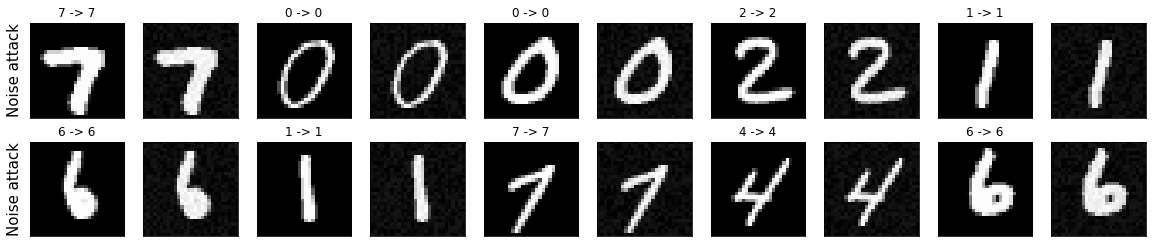



[Validation] Loss: 0.0161 Accuracy: 91.9400%)


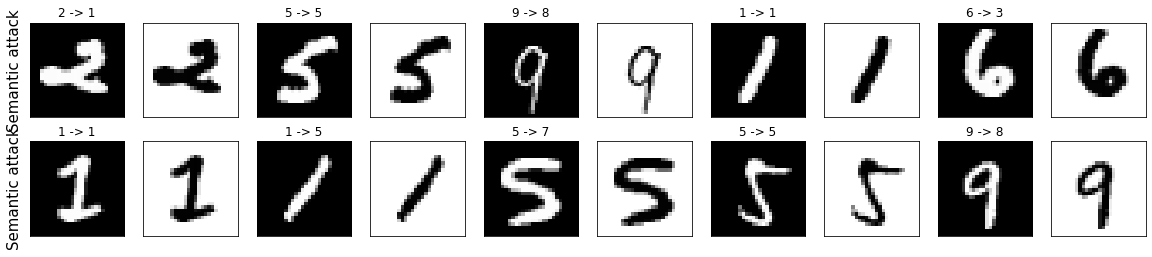



[Validation] Loss: 0.2344 Accuracy: 52.8600%)


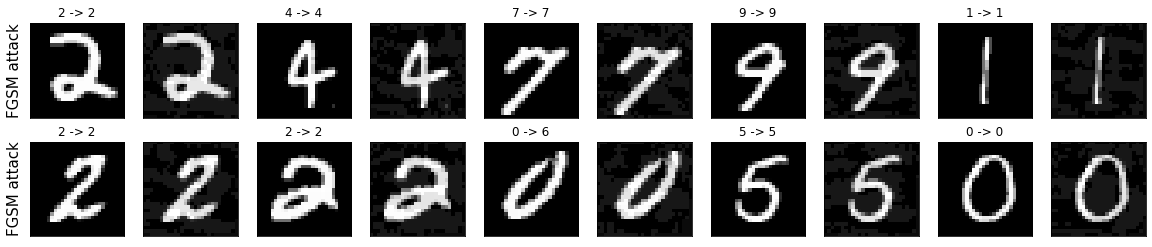



[Validation] Loss: 0.0353 Accuracy: 88.7450%)


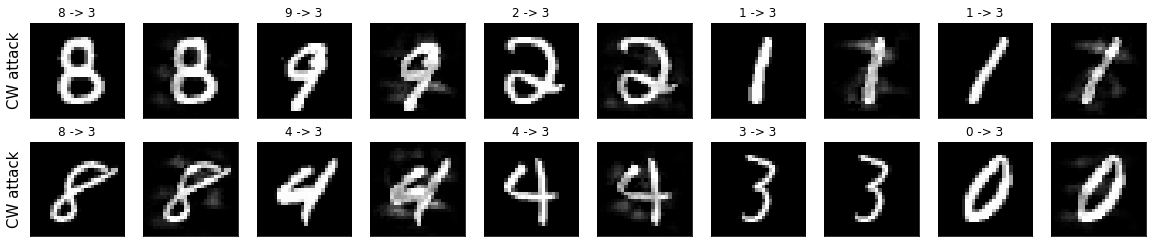



[Validation] Loss: 0.0001 Accuracy: 5.0000%)


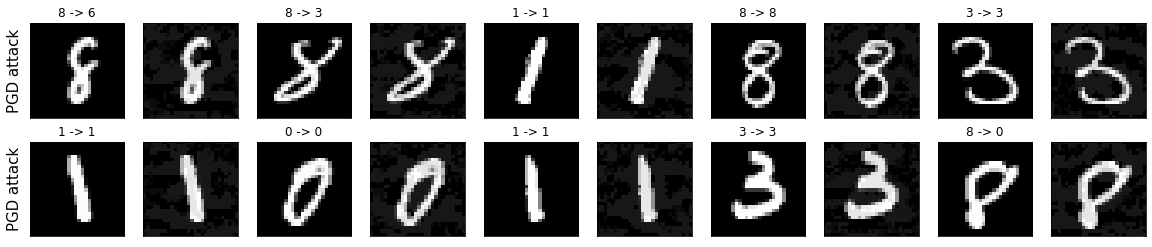



[Validation] Loss: 0.0398 Accuracy: 86.5550%)


In [7]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,cur_running_loss,running_acc):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= noi(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= sem(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= FGSM(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= CW(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= PGD(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))


# Attack (epsilon=0.1)

In [8]:
criterion = nn.CrossEntropyLoss()

def noi(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = noise(data.to(device),0.1)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'Noise attack',epoch_loss,epoch_acc

def PGD(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = projected_gradient_descent(model, data.to(device),0.1,0.05,40,np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'PGD attack',epoch_loss,epoch_acc

def FGSM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = fast_gradient_method(model, data.to(device), 0.1, np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200

  return adver_example,adver_target,clean_example,clean_target,'FGSM attack',epoch_loss,epoch_acc


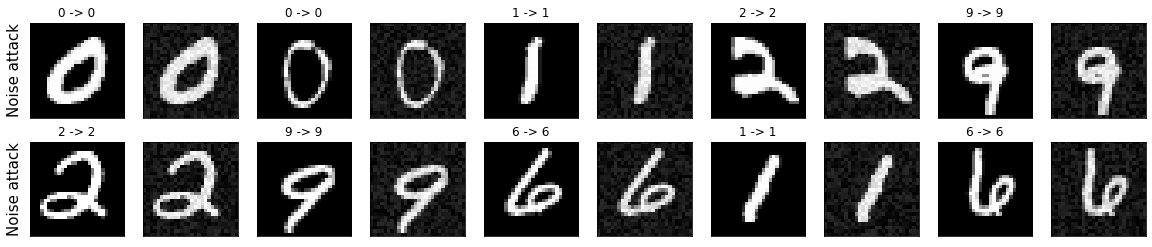



[Validation] Loss: 0.0163 Accuracy: 93.4250%)


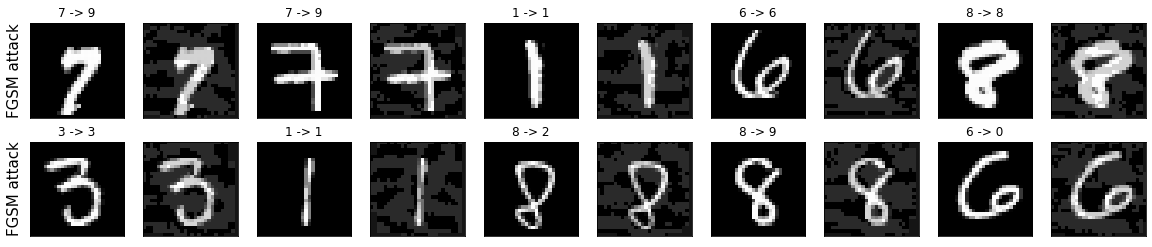



[Validation] Loss: 0.0924 Accuracy: 78.6600%)


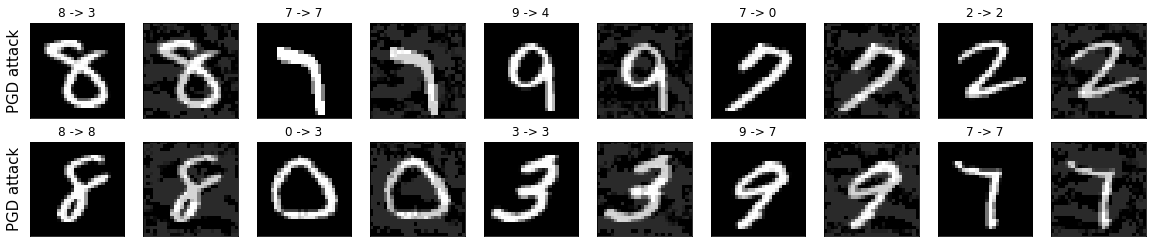



[Validation] Loss: 0.1362 Accuracy: 70.3450%)


In [9]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,cur_running_loss,running_acc):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')
adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= noi(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= FGSM(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= PGD(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

# Attack (epsilon=0.2)

In [10]:
criterion = nn.CrossEntropyLoss()

def noi(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = noise(data.to(device),0.2)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'Noise attack',epoch_loss,epoch_acc

def PGD(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)

  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    #if i>=1:
      #break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = projected_gradient_descent(model, data.to(device),0.2,0.05,40,np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200
    
  return adver_example,adver_target,clean_example,clean_target,'PGD attack',epoch_loss,epoch_acc

def FGSM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = fast_gradient_method(model, data.to(device), 0.2, np.inf)
    outputs = model(adver_example)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200

  return adver_example,adver_target,clean_example,clean_target,'FGSM attack',epoch_loss,epoch_acc


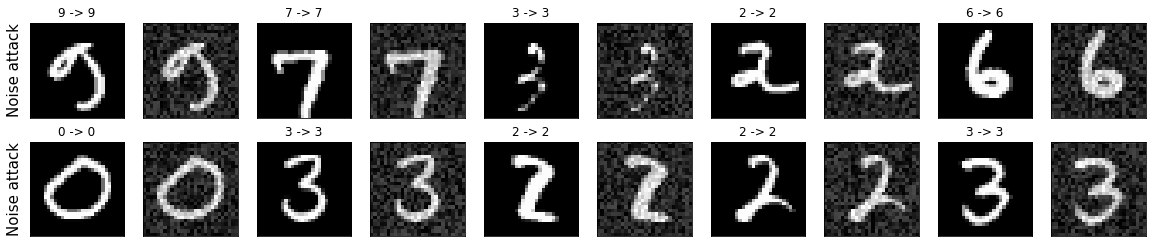



[Validation] Loss: 0.0168 Accuracy: 93.2800%)


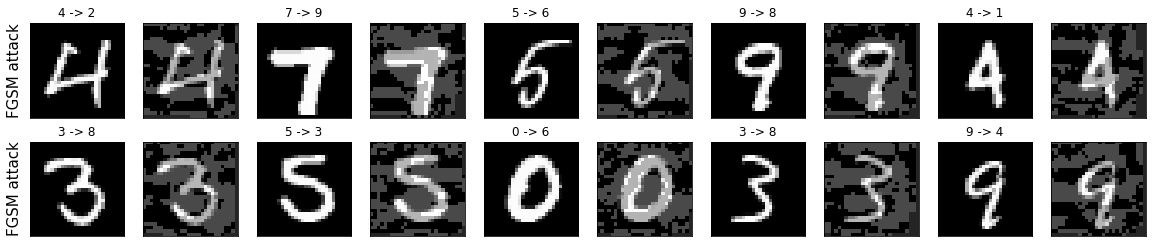



[Validation] Loss: 0.2930 Accuracy: 53.7200%)


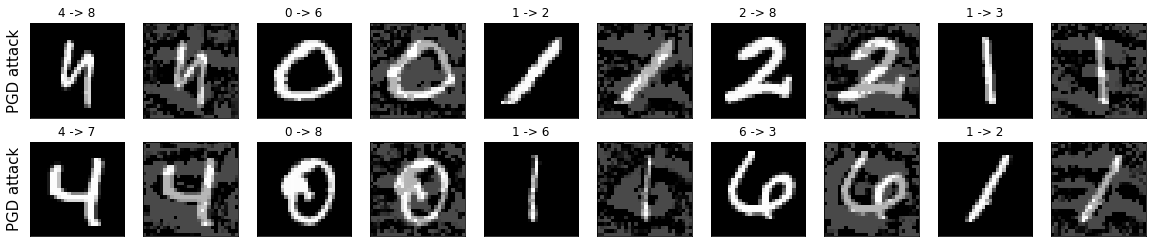



[Validation] Loss: 0.5923 Accuracy: 46.6600%)


In [11]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,cur_running_loss,running_acc):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')
adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= noi(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= FGSM(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= PGD(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name,epoch_loss,epoch_acc)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

# Defense

In [12]:
class Processor(nn.Module):

    def __init__(self):
        super(Processor, self).__init__()

    def forward(self, x):
        return x

    def extra_repr(self):
        return 'EmptyDefense (Identity)'

class FloatToIntSqueezing(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, max_int, vmin, vmax):
        # here assuming 0 =< x =< 1
        x = (x - vmin) / (vmax - vmin)
        x = torch.round(x * max_int) / max_int
        return x * (vmax - vmin) + vmin

    @staticmethod
    def backward(ctx, grad_output):
        raise NotImplementedError(
            "backward not implemented", FloatToIntSqueezing)

In [13]:
class BitSqueezing(Processor):

    def __init__(self, bit_depth, vmin=0., vmax=1.):
        super(BitSqueezing, self).__init__()

        self.bit_depth = bit_depth
        self.max_int = 2 ** self.bit_depth - 1
        self.vmin = vmin
        self.vmax = vmax

    def forward(self, x):
        return FloatToIntSqueezing.apply(
            x, self.max_int, self.vmin, self.vmax)

In [14]:
bits_squeezing = BitSqueezing(bit_depth=5)
defense = nn.Sequential(
    bits_squeezing,
)

def predict_from_logits(logits, dim=1):
    return logits.max(dim=dim, keepdim=False)[1]

def DFGSM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = fast_gradient_method(model, data.to(device), 0.2, np.inf)
    adv_defended =defense(adver_example)
    outputs = model(adv_defended)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200

  return adver_example,adver_target,adv_defended,clean_example,clean_target,'FGSM attack',epoch_loss,epoch_acc

def DPGM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  running_loss = 0.
  running_corrects = torch.tensor(0).to(device)
    
  for i,(data,target) in enumerate(test_loader):
    target = target.to(device)
    data = data.to(device)
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = projected_gradient_descent(model, data.to(device),0.2,0.05,40,np.inf)
    adv_defended =defense(adver_example)
    outputs = model(adv_defended)
    preds = outputs.max(1, keepdim=True)[1]
    adver_target = torch.max(outputs,1)[1]
    clean_example = data
    clean_target = target
    
    loss = criterion(outputs, target)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == target)
    
  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects/200

    
  return adver_example,adver_target,adv_defended,clean_example,clean_target,'FGSM attack',epoch_loss,epoch_acc


In [15]:
adver_example,adver_target,adv_defended,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= DFGSM(simple_model)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))
adver_example,adver_target,adv_defended,clean_example,clean_target,attack_name,epoch_loss,epoch_acc= DPGM(simple_model)
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}%)'.format(epoch_loss, epoch_acc))

[Validation] Loss: 0.2839 Accuracy: 55.0650%)
[Validation] Loss: 0.5718 Accuracy: 46.9750%)
